Reproduce: Analytic
====================

## Simulating Transient Response over a Conductive Sphere

Here we simulate the transient response from a conductive sphere in a vacuum. The sphere has a conductivity of $\sigma$ = 100 S/m. The center of the sphere is located at (0,0,-50) and has a radius of $a$ = 8 m.

The transient response is simulated for x, y and z oriented magnetic dipoles at (-5, 0, 10). The x, y and z components of H and dB/dt are simulated at (5, 0, 10). However, we only plot the data for horizontal coaxial, horizontal coplanar and vertical coplanar geometries.

## Package Details

Wait and Spies analytic solution. See https://em.geosci.xyz/content/maxwell3_fdem/inductive_sources/sphere/index.html for a summary of the solution.

*Reference:* J. R. Wait. A conductive sphere in a time varying magnetic field. Geophysics, 16:666–672, 1951.

## Reproducing the Forward Simulation Result

We begin by loading all necessary packages and setting any global parameters for the notebook.

In [1]:
from SimPEG.utils import mkvc
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.constants import mu_0
import scipy.special as spec

mpl.rcParams.update({"font.size": 14})
write_output = True

Define layered Earth model.

In [2]:
rootdir = './../../../assets/tdem/sphere_vacuum_conductive_fwd_simpeg/'

a = 8                                # radius of sphere
sig0 = 1e-8                          # background conductivity
sig = 1e2                            # electrical conductivity of sphere
mur = 1                              # relative permeability of sphere
xyzs = np.c_[0., 0., -50.]           # xyz location of the sphere

Here, we define the survey geometry for the forward simulation.

In [3]:
xyz_tx = np.c_[-5., 0., 10.]         # Transmitter location
xyz_rx = np.c_[5., 0., 10.]          # Receiver location
times = np.logspace(-5,-2,10)        # Times
tx_moment = 1                        # Dipole moment

Here we define some functions required for the forward simulation.

In [4]:
def compute_primary_field_dipole(orientation, pxyz, qxyz):
    """
    For an X, Y or Z orientationed magnetic dipole, compute the free-space primary field for a dipole moment of 1.
    
    orientation: 'x', 'y' or 'z'
    pxyz : [x,y,z] locations of the dipole transmitters
    qxyz : [x,y,z] location at the centre location of the sphere
    
    """

    R = np.sqrt((qxyz[0] - pxyz[:,0]) ** 2 + (qxyz[1] - pxyz[:,1]) ** 2 + (qxyz[2] - pxyz[:,2]) ** 2)

    if orientation == "x":
        Hpx = (1 / (4 * np.pi)) * (3 * (qxyz[0] - pxyz[:,0]) * (qxyz[0] - pxyz[:,0]) / R ** 5 - 1 / R ** 3)
        Hpy = (1 / (4 * np.pi)) * (3 * (qxyz[1] - pxyz[:,1]) * (qxyz[0] - pxyz[:,0]) / R ** 5)
        Hpz = (1 / (4 * np.pi)) * (3 * (qxyz[2] - pxyz[:,2]) * (qxyz[0] - pxyz[:,0]) / R ** 5)
    elif orientation == "y":
        Hpx = (1 / (4 * np.pi)) * (3 * (qxyz[0] - pxyz[:,0]) * (qxyz[1] - pxyz[:,1]) / R ** 5)
        Hpy = (1 / (4 * np.pi)) * (3 * (qxyz[1] - pxyz[:,1]) * (qxyz[1] - pxyz[:,1]) / R ** 5 - 1 / R ** 3)
        Hpz = (1 / (4 * np.pi)) * (3 * (qxyz[2] - pxyz[:,2]) * (qxyz[1] - pxyz[:,1]) / R ** 5)
    elif orientation == "z":
        Hpx = (1 / (4 * np.pi)) * (3 * (qxyz[0] - pxyz[:,0]) * (qxyz[2] - pxyz[:,2]) / R ** 5)
        Hpy = (1 / (4 * np.pi)) * (3 * (qxyz[1] - pxyz[:,1]) * (qxyz[2] - pxyz[:,2]) / R ** 5)
        Hpz = (1 / (4 * np.pi)) * (3 * (qxyz[2] - pxyz[:,2]) * (qxyz[2] - pxyz[:,2]) / R ** 5 - 1 / R ** 3)

    return np.c_[Hpx, Hpy, Hpz]


def compute_dipolar_response(m, pxyz, qxyz):
    """
    For a sphere with dipole moment [mx, my, mz], compute the dipolar response
    
    m : dipole moments [mx, my, mz]
    orientation of the receiver: 'x', 'y' or 'z'
    pxyz : [x,y,z] locations of the receivers
    qxyz : [x,y,z] location at the centre location of the sphere
    
    """

    R = np.sqrt((qxyz[:,0] - pxyz[:,0]) ** 2 + (qxyz[:,1] - pxyz[:,1]) ** 2 + (qxyz[:,2] - pxyz[:,2]) ** 2)

    Hx = (1 / (4 * np.pi)) * ( 3 * (pxyz[:,0] - qxyz[:,0]) * (
                m[:,0]*(pxyz[:,0] - qxyz[:,0]) +
                m[:,1]*(pxyz[:,1] - qxyz[:,1]) +
                m[:,2]*(pxyz[:,2] - qxyz[:,2])
            ) / R ** 5 - m[:,0] / R ** 3)

    Hy = (1 / (4 * np.pi)) * ( 3 * (pxyz[:,1] - qxyz[:,1]) * (
                m[:,0]*(pxyz[:,0] - qxyz[:,0]) +
                m[:,1]*(pxyz[:,1] - qxyz[:,1]) +
                m[:,2]*(pxyz[:,2] - qxyz[:,2])
            ) / R ** 5 - m[:,1] / R ** 3)

    Hz = (1 / (4 * np.pi)) * ( 3 * (pxyz[:,2] - qxyz[:,2]) * (
                m[:,0]*(pxyz[:,0] - qxyz[:,0]) +
                m[:,1]*(pxyz[:,1] - qxyz[:,1]) +
                m[:,2]*(pxyz[:,2] - qxyz[:,2])
            ) / R ** 5 - m[:,2] / R ** 3)

    return np.c_[Hx, Hy, Hz]

def compute_coefficients(N):
    
    eta = np.pi*np.linspace(1,N,N)
    for ii in range(0, 20):
        eta = np.pi*np.linspace(1,N,N) + np.arctan(((mur - 1)*eta)/(mur - 1 + eta**2))
    
    return eta



def compute_excitation_factor(t, eta, sig, mur, a):
    """
    Compute Excitation Factor (FEM)
    
    t : times
    eta : coefficients
    sig : conductivity
    mur : relative permeability
    a : radius
    """
    
    alpha = (mur + 2)*(mur - 1)
    beta = np.sqrt(4*np.pi*1e-7*mur*sig)*a
    
    chi = len(t)*[None]
    for ii in range(0, len(t)):
        chi[ii] = 9 * mur * np.sum(
            np.exp(-t[ii] * eta**2 / beta**2) / (alpha + eta**2)
        )
    
    return chi


def compute_excitation_factor_derivative(t, eta, sig, mur, a):
    """
    Compute Excitation Factor (FEM)
    
    t : times
    eta : coefficients
    sig : conductivity
    mur : relative permeability
    a : radius
    """
    
    alpha = (mur + 2)*(mur - 1)
    beta = np.sqrt(4*np.pi*1e-7*mur*sig)*a
    
    dchi = len(t)*[None]
    for ii in range(0, len(t)):
        dchi[ii] = -(9 * mur / beta**2) * np.sum(
            eta**2 * np.exp(-t[ii] * eta**2 / beta**2) / (alpha + eta**2)
        )
    
    return dchi

Finally, we simulate the predicted data.

In [5]:
# Compute coefficients
eta = compute_coefficients(500)

H_analytic = []
dBdt_analytic = []

for ii, comp in enumerate(['x','y','z']):
    
    # Compute the free space primary field at the location of the sphere
    Hp = mkvc(tx_moment*compute_primary_field_dipole(comp, xyz_tx, mkvc(xyzs)))

    # Compute dipole moment and its time derivative
    chi = compute_excitation_factor(times, eta, sig, mur, a)
    dchi = compute_excitation_factor_derivative(times, eta, sig, mur, a)
    m = (4*np.pi*a**3/3) * np.outer(chi, Hp)
    dmdt = (4*np.pi*a**3/3) * np.outer(dchi, Hp)

    # Predict data
    H_analytic.append(compute_dipolar_response(m, xyz_rx, xyzs))
    dBdt_analytic.append(mu_0*compute_dipolar_response(dmdt, xyz_rx, xyzs))

We can export the data.

In [6]:
if write_output:
    
    fname_analytic = rootdir + 'dpred_analytic.txt'
    
    header = 'TIME HX HY HZ DBDTX DBDTY DBDTZ'
    
    t_column = np.kron(np.ones(3), times)

    dpred_analytic = np.c_[t_column, np.vstack(H_analytic), np.vstack(dBdt_analytic)]

    fid = open(fname_analytic, 'w')
    np.savetxt(fid, dpred_analytic, fmt='%.6e', delimiter=' ', header=header)
    fid.close()

## Plotting Simulated Data

Here, we plot the H and dB/dt data for horizontal coaxial, horizontal coplanar and vertical coplanar geometries.

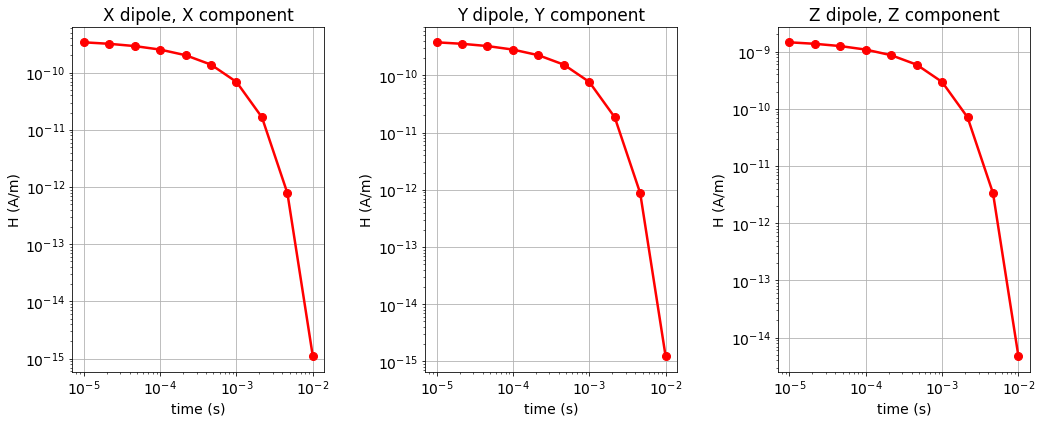

In [7]:
fig = plt.figure(figsize=(14, 6))
lw = 2.5
ms = 8

ax1 = 3*[None]

for ii, comp in enumerate(['X','Y','Z']):

    ax1[ii] = fig.add_axes([0.05+0.35*ii, 0.1, 0.25, 0.8])
    ax1[ii].loglog(times, H_analytic[ii][:, ii], 'r-o', lw=lw, markersize=8)
    ax1[ii].set_xticks([1e-5, 1e-4, 1e-3, 1e-2])
    ax1[ii].grid()
    ax1[ii].set_xlabel('time (s)')
    ax1[ii].set_ylabel('H (A/m)'.format(comp))
    ax1[ii].set_title(comp + ' dipole, ' + comp + ' component')

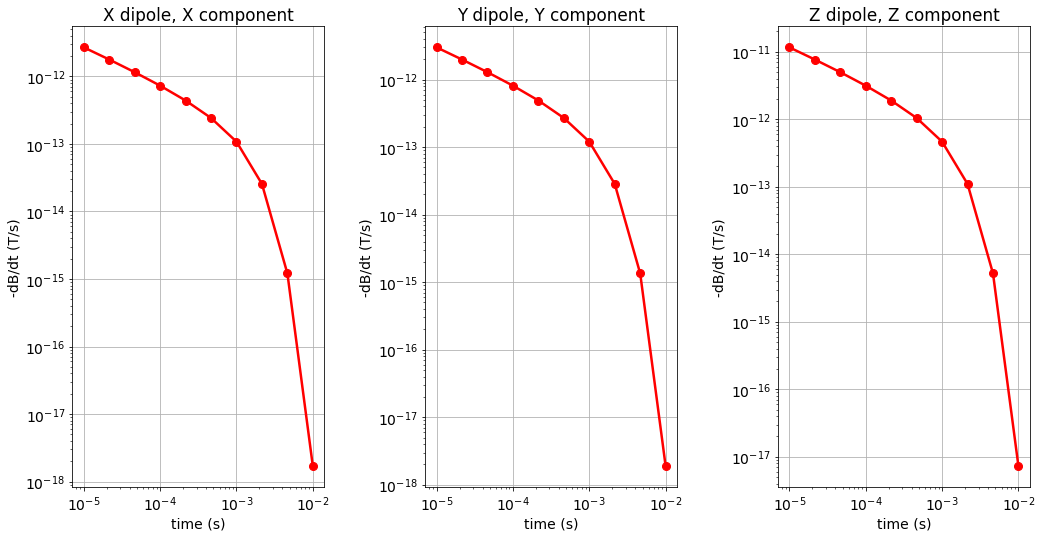

In [8]:
fig = plt.figure(figsize=(14, 8))
lw = 2.5
ms = 8

ax1 = 3*[None]

for ii, comp in enumerate(['X','Y','Z']):

    ax1[ii] = fig.add_axes([0.05+0.35*ii, 0.1, 0.25, 0.8])
    ax1[ii].loglog(times, -dBdt_analytic[ii][:, ii], 'r-o', lw=lw, markersize=8)
    ax1[ii].set_xticks([1e-5, 1e-4, 1e-3, 1e-2])
    ax1[ii].grid()
    ax1[ii].set_xlabel('time (s)')
    ax1[ii].set_ylabel('-dB/dt (T/s)'.format(comp))
    ax1[ii].set_title(comp + ' dipole, ' + comp + ' component')